In [1]:
import seaborn as sb
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import cleaned listings table
listings_cleaned_df = pd.read_csv('./Resources/listings_cleaned.csv')
listings_cleaned_df.head(2)

,id,name,host_id,street,neighbourhood,zipcode,property_type,room_type,accommodates,bathrooms,...,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,avg_availability
0,241032,Stylish Queen Anne Apartment,956883,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,98119,Apartment,Entire home/apt,4,1.0,...,-1.0,2,5.0,1,365,True,moderate,True,True,0.721709
1,953595,Bright & Airy Queen Anne Apartment,5177328,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,98119,Apartment,Entire home/apt,4,1.0,...,40.0,1,0.0,2,90,True,strict,True,True,0.406260


In [3]:
# extract columns containing continuous values for analysis
# first column is "price", which we will compare against many other factors
scaled_cols = [14,8,9,10,11,13,15,16,17,18,20,21,22,27]
scaled_cols_df = listings_cleaned_df.iloc[:, scaled_cols]

scaled_col_list = scaled_cols_df.columns.to_list()
x_axis = scaled_col_list[0] # split out price
y_axes = scaled_col_list[1:] # all other continuous factor columns
scaled_cols_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             3818 non-null   float64
 1   accommodates      3818 non-null   int64  
 2   bathrooms         3818 non-null   float64
 3   bedrooms          3818 non-null   int64  
 4   beds              3818 non-null   int64  
 5   amenities_count   3818 non-null   int64  
 6   weekly_price      3818 non-null   float64
 7   monthly_price     3818 non-null   float64
 8   security_deposit  3818 non-null   float64
 9   cleaning_fee      3818 non-null   float64
 10  extra_people      3818 non-null   float64
 11  minimum_nights    3818 non-null   int64  
 12  maximum_nights    3818 non-null   int64  
 13  avg_availability  3818 non-null   float64
dtypes: float64(8), int64(6)
memory usage: 417.7 KB


C:\Users\fu5i1\anaconda3real\envs\dev\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


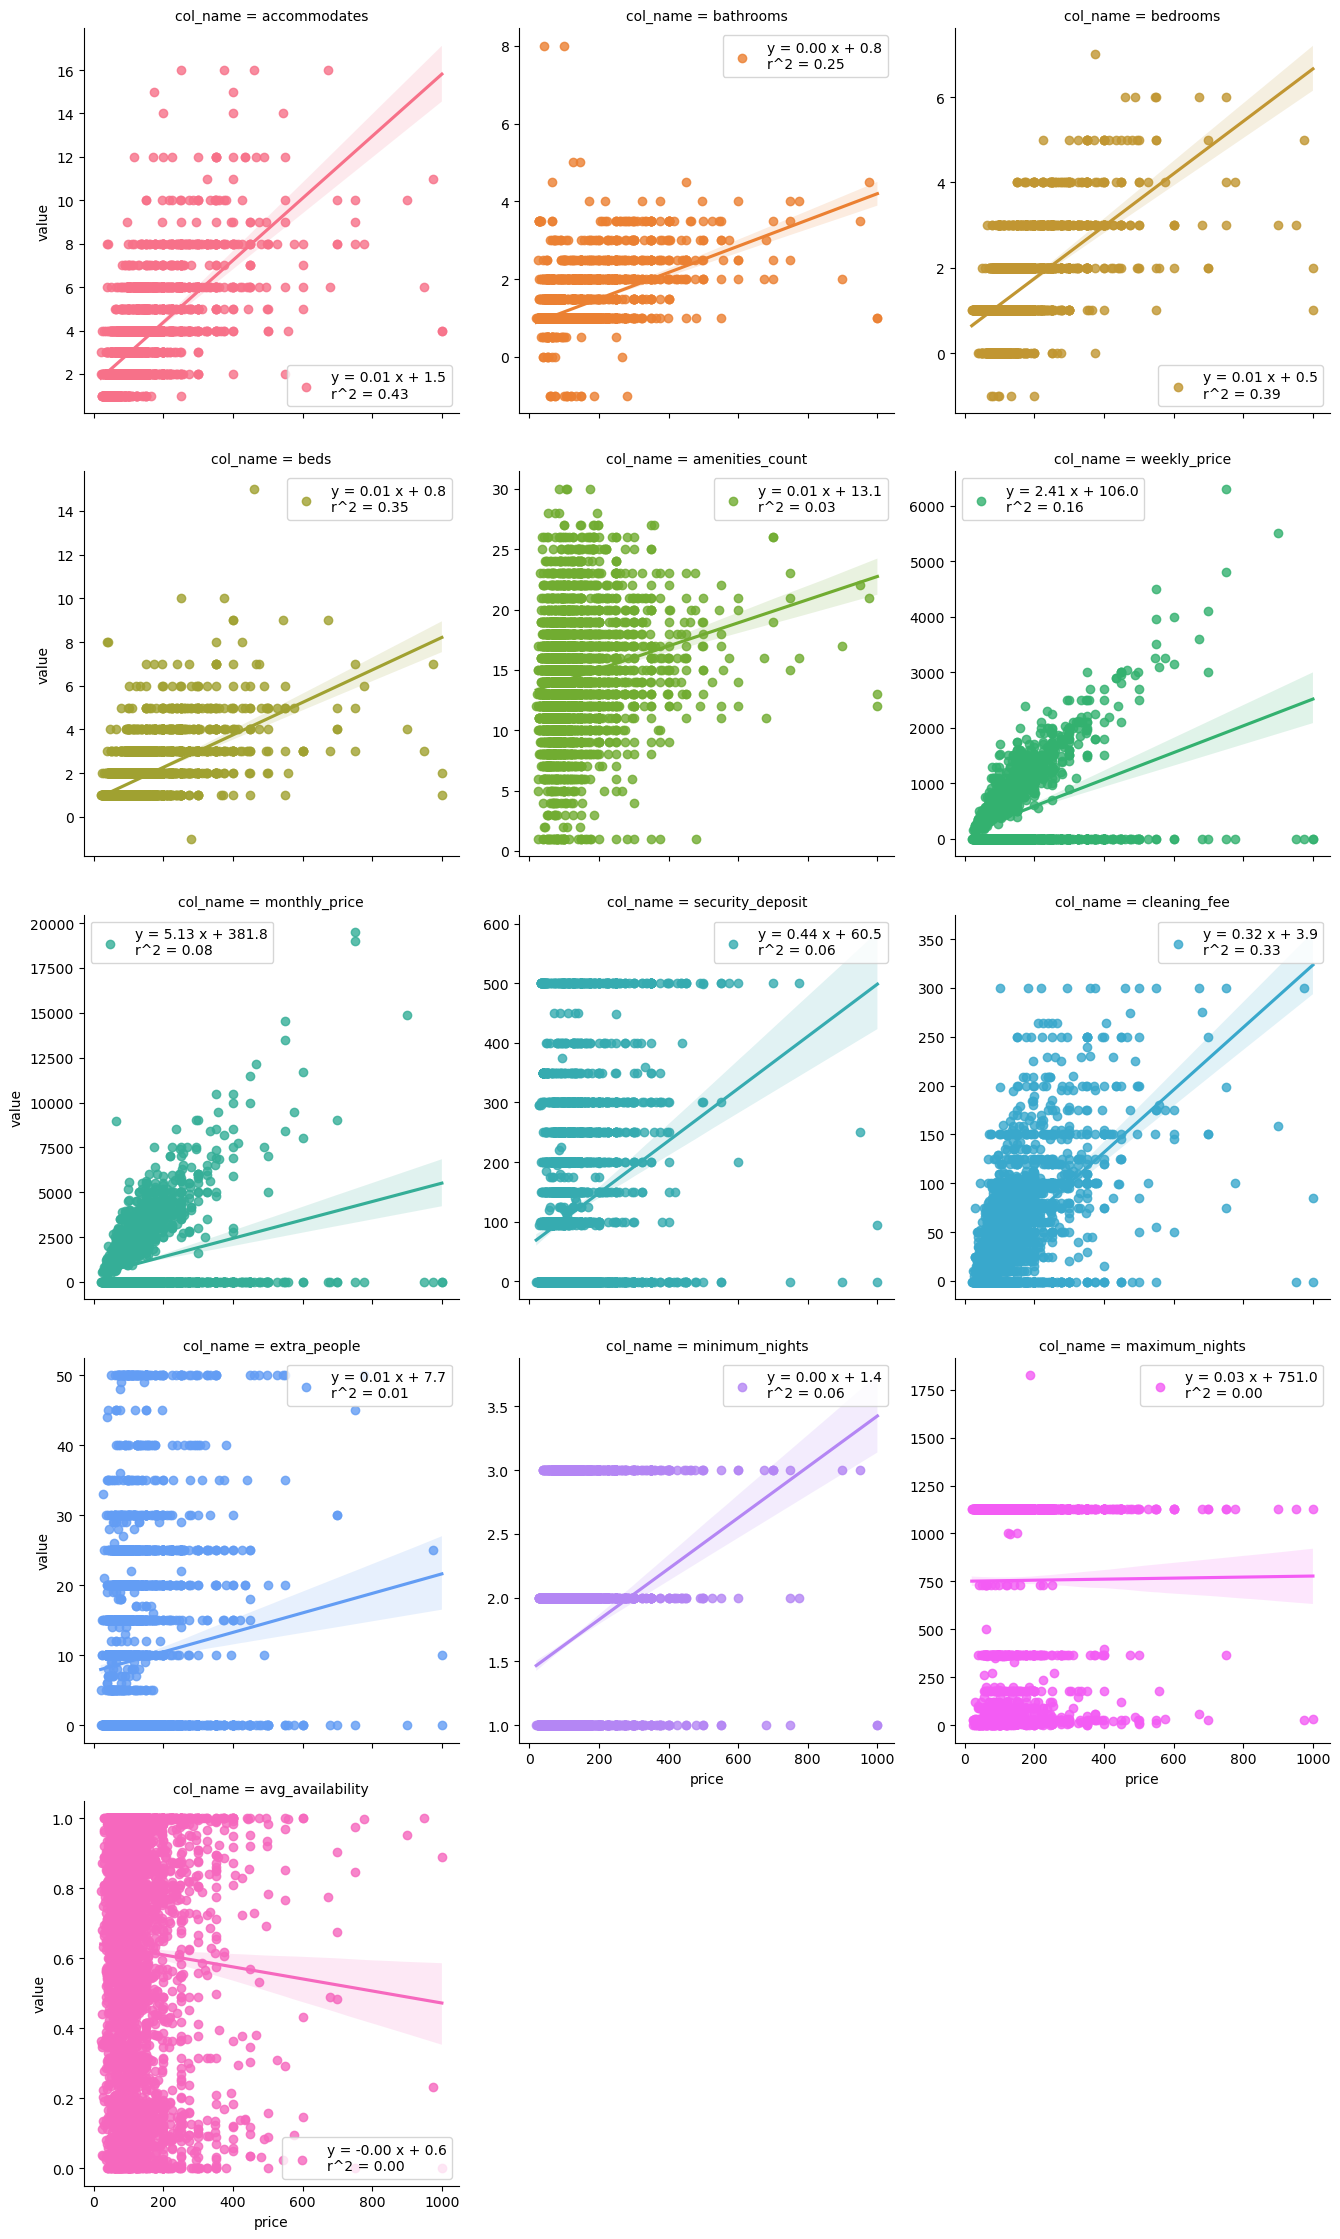

In [5]:
# reshape dataframe to work with Seaborn lmplot()
scaled_long_df = scaled_cols_df.melt('price', var_name='col_name', value_name='value')

# drop NA
scaled_long_df = scaled_long_df.dropna()
labels_list = [] # for adding line equations and r^2 values once calculated

# columns in which outliers were observed in original plotting pass
outliers_observed = ['maximum_nights', 'minimum_nights', 'security_deposit', 'extra_people']
for y in y_axes:
    # work with one y-axis set at a time
    curr_data = scaled_long_df.loc[scaled_long_df['col_name'] == y]['value']
    
    # extreme outliers observed in these cols; removing via this method improves graphs
    if (y in outliers_observed):
        # identify outlier ranges; reused from unit 5
        quarts = curr_data.quantile([.25,.5,.75])
        lowerq = quarts[0.25]
        upperq = quarts[0.75]
        iqr = upperq - lowerq
        lower_bound = lowerq - (1.5*iqr)
        upper_bound = upperq + (1.5*iqr)

        # cull outliers; use conditionals to drop outlier rows
        outliers_idx = scaled_long_df[
            (scaled_long_df['col_name'] == y) & (
                (scaled_long_df['value'] > upper_bound) | 
                (scaled_long_df['value'] < lower_bound)
            )
        ].index
        scaled_long_df.drop(outliers_idx, inplace=True)
    
    # get data after removal of outliers
    updated_data = scaled_long_df.loc[scaled_long_df['col_name'] == y]
    x_values = updated_data['price']
    y_values = updated_data['value']
    (slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
    curr_r2 = rvalue ** 2
    labels_list.append(f"y = {slope:.2f} x + {intercept:.1f}\nr^2 = {curr_r2:.2f}")


# plot with seaborn
seaplot = sb.lmplot(data=scaled_long_df, x='price', y='value', col='col_name', hue='col_name', 
          col_wrap=3, facet_kws={'sharey': False}, height=4.5)

# add line equations
ax = seaplot.axes
i = 0
for axis in ax:
    axis.legend()
    curr_legend = axis.get_legend()
    legend_labels = curr_legend.get_texts()
    legend_labels[0].set_text(labels_list[i])
    i += 1

C:\Users\fu5i1\anaconda3real\envs\dev\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


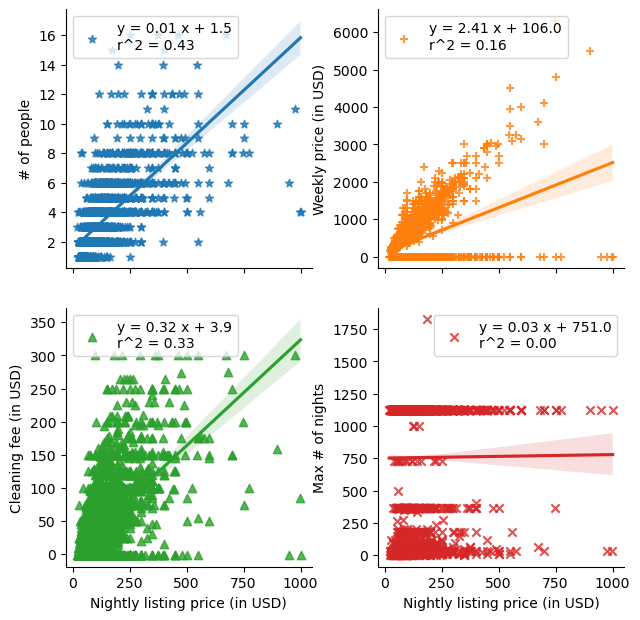

In [6]:
# pick out example of plots with good / okay / bad r^2 values
snapshot_long_df = scaled_long_df.loc[
    (scaled_long_df['col_name'] == 'weekly_price') |
    (scaled_long_df['col_name'] == 'maximum_nights') |
    (scaled_long_df['col_name'] == 'accommodates') |
    (scaled_long_df['col_name'] == 'cleaning_fee')
]
snapshot_idx = [0, 5, 8, 11]
snapshot_labels = [labels_list[i] for i in snapshot_idx]

seaplot = sb.lmplot(data=snapshot_long_df, x='price', y='value', col='col_name', hue='col_name', 
          col_wrap=2, facet_kws={'sharey': False}, height=3.25, markers=['*', '+', '^', 'x'])

# plot formatting
ylabels = ['# of people', 'Weekly price (in USD)', 'Cleaning fee (in USD)', 'Max # of nights']
xlabel = 'Nightly listing price (in USD)'                               
ax = seaplot.axes
i = 0
for axis in ax:
    axis.set(xlabel=xlabel, ylabel=ylabels[i], title='')
    axis.legend()
    curr_legend = axis.get_legend()
    legend_labels = curr_legend.get_texts()
    legend_labels[0].set_text(snapshot_labels[i])
    i += 1

In [8]:
# bar charts for counts of distinct values for categorical data
bar_cols = [14,4,5,6,7,12,23,24,25,26]
bar_df = listings_cleaned_df.iloc[:, bar_cols]
bar_col_names = bar_df.columns.to_list()
bar_df.info()

# attempted to make set of bar graphs for categorical data;
# process a little too complicated to complete during our allotted time

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   price                             3818 non-null   float64
 1   neighbourhood                     3402 non-null   object 
 2   zipcode                           3818 non-null   int64  
 3   property_type                     3817 non-null   object 
 4   room_type                         3818 non-null   object 
 5   bed_type                          3818 non-null   object 
 6   instant_bookable                  3818 non-null   bool   
 7   cancellation_policy               3818 non-null   object 
 8   require_guest_profile_picture     3818 non-null   bool   
 9   require_guest_phone_verification  3818 non-null   bool   
dtypes: bool(3), float64(1), int64(1), object(5)
memory usage: 220.1+ KB


In [1]:
# break out zipcode and price
zip_prices_df = bar_df[bar_df['zipcode'] != -1].iloc[:, [0,2]]
zip_counts_df = zip_prices_df.groupby('zipcode').count().rename(columns={'price':'count'}).reset_index()

# create another DF with just the top 200 listings by price
zip_sorted_df = zip_prices_df.sort_values('price', ascending=False)
top_200_df = zip_sorted_df.head(200)
top_200_counts_df = top_200_df.groupby('zipcode').count().rename(columns={'price':'count'}).reset_index()
top_200_counts_df.head()

NameError: name 'bar_df' is not defined

C:\Users\fu5i1\anaconda3real\envs\dev\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


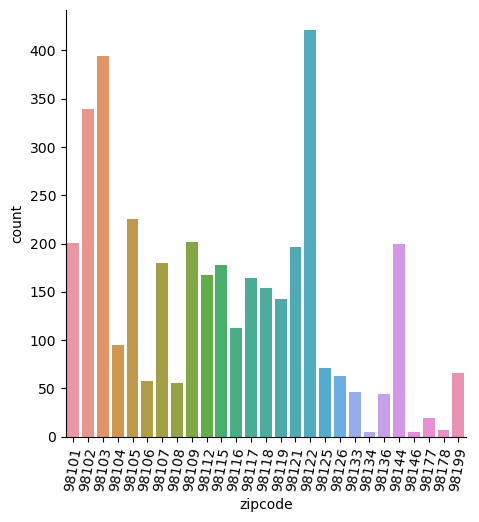

In [11]:
# bar chart for full dataset
all_zip_counts_bar = sb.catplot(kind='bar', data=zip_counts_df, x='zipcode', y='count')
all_zip_counts_bar.set_xticklabels(rotation=80)

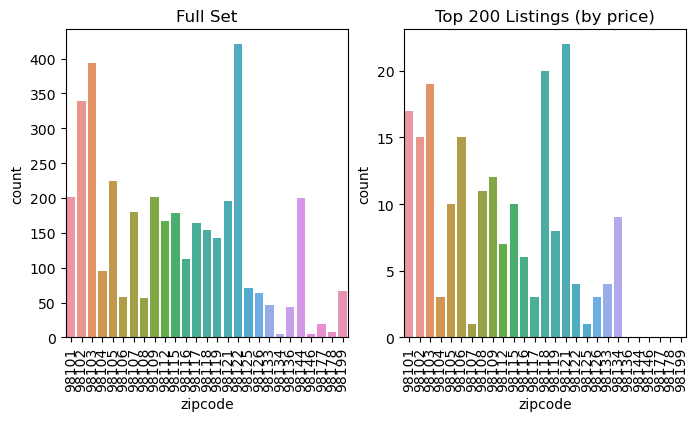

In [12]:
# example matplotlib integration found here: https://seaborn.pydata.org/examples/palette_choices.html
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

# create double plot for both full dataset and top 200 side-by-side
x = zip_counts_df['zipcode']
y1 = zip_counts_df['count']
sb1 = sb.barplot(x=x, y=y1, ax=ax1)

y2 = top_200_counts_df['count']
sb2 = sb.barplot(x=x, y=y2, ax=ax2)

sb1.set_xticklabels(rotation=90, labels=x)
sb2.set_xticklabels(rotation=90, labels=x)
ax1.set_title('Full Set')
ax2.set_title('Top 200 Listings (by price)')
plt.show()

<Axes: xlabel='cancellation_policy', ylabel='price'>

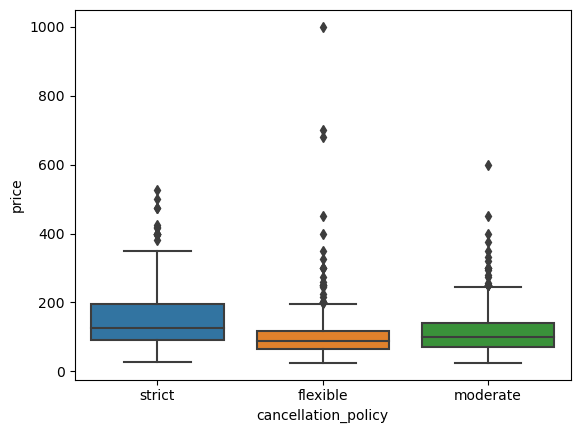

In [14]:
# generate DF from cancellation_policy and price columns
cancel_price_df = bar_df.iloc[:, [0,7]]

# random sample to attempt ANOVA
# sample source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html
sample_size = 400
strict_sample = cancel_price_df[cancel_price_df['cancellation_policy'] == 'strict'].sample(sample_size)
moderate_sample = cancel_price_df[cancel_price_df['cancellation_policy'] == 'moderate'].sample(sample_size)
flexible_sample = cancel_price_df[cancel_price_df['cancellation_policy'] == 'flexible'].sample(sample_size)

# recombine samples
sampled_df = pd.concat([strict_sample, flexible_sample, moderate_sample])

# create boxplot
sb.boxplot(sampled_df, x='cancellation_policy', y='price')

In [21]:
# demonstrate viability of analysis on multiple merged tables
# neighborhood, property_type, and merge col id from listings table
calendar_cols = [0,4,14]
calendar_df = listings_cleaned_df.iloc[:, calendar_cols]

avg_price_df = pd.read_csv('./Resources/calendar_average pricing.csv')
ten_ids = avg_price_df['listing_id'].unique()[0:11]

calendar_df.head()

,id,neighbourhood,price
0,241032,Queen Anne,85.0
1,953595,Queen Anne,150.0
2,3308979,Queen Anne,975.0
3,7421966,Queen Anne,100.0
4,278830,Queen Anne,450.0


In [26]:
# break out a small subset of listings to observe over time
sub_dfs = []
for i in ten_ids:
    curr_data = avg_price_df[avg_price_df['listing_id'] == i]
    price = calendar_df[calendar_df['id'] == curr_data['listing_id'].iloc[0]]['price'].iloc[0]
    neigh = calendar_df[calendar_df['id'] == curr_data['listing_id'].iloc[0]]['neighbourhood'].iloc[0]
    curr_data['listing_id'] = '$' + str(price) + ' ' + neigh
    curr_data.rename(columns={'listing_id': 'Property'}, inplace=True)
    sub_dfs.append(curr_data)
ten_ids_df = pd.concat(sub_dfs)
ten_ids_df.head()

C:\Users\fu5i1\AppData\Local\Temp\ipykernel_13588\1511390373.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_data['listing_id'] = '$' + str(price) + ' ' + neigh
C:\Users\fu5i1\AppData\Local\Temp\ipykernel_13588\1511390373.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_data.rename(columns={'listing_id': 'Property'}, inplace=True)


,Property,month,price
0,$120.0 Dunlap,2,120.0
1,$120.0 Dunlap,3,120.0
2,$120.0 Dunlap,4,120.0
3,$120.0 Dunlap,5,120.0
4,$120.0 Dunlap,6,120.0


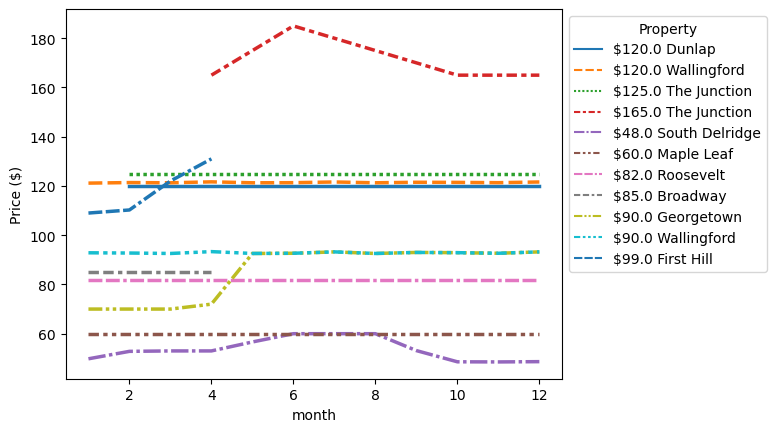

In [31]:
# pivot code built off of: https://pandas.pydata.org/pandas-docs/version/0.13.1/reshaping.html
ten_pivot_df = ten_ids_df.pivot(index='month', columns='Property', values='price')

sb3 = sb.lineplot(data=ten_pivot_df, palette="tab10", linewidth=2.5)
sb.move_legend(sb3, "upper left", bbox_to_anchor=(1, 1))
sb3.set_ylabel("Price ($)")
plt.show()